In [ ]:
!pip install noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.colors as mcolors
from noise import pnoise2

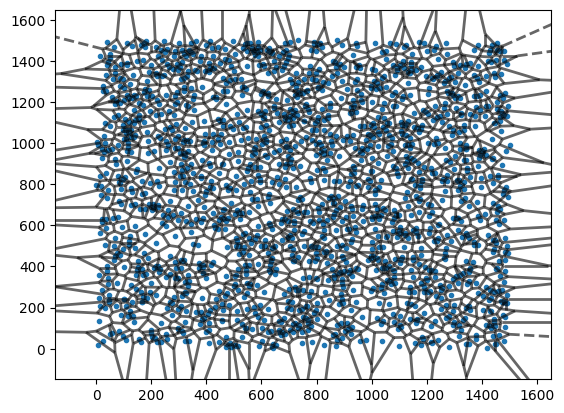

In [ ]:
#Initial voronoi diagram

canvasX = 1500
canvasY = 1500
n = random.randint(1000, 2000)
test_points = np.empty((n, 2), dtype=int)

for i in range(n):
  x = random.randint(1, canvasX)
  y = random.randint(1, canvasY)
  test_points[i] = [x, y]

vor = Voronoi(test_points)
voronoi_plot_2d(vor, show_vertices=False, line_width=2, line_alpha=0.6)
plt.show()

In [ ]:
#computing centroid of cell

def compute_centroid(vor, region):
    verts = vor.vertices[region]
    signed_area = 0
    cx = 0
    cy = 0

    for i in range(len(verts) - 1):
        x0, y0 = verts[i]
        x1, y1 = verts[i+1]
        a = x0 * y1 - x1 * y0
        signed_area += a
        cx += (x0 + x1) * a
        cy += (y0 + y1) * a

    signed_area *= 0.5
    if signed_area == 0:
        return verts[0]

    cx /= (6 * signed_area)
    cy /= (6 * signed_area)

    return [cx, cy]

In [ ]:
#Clamping centroid to bounding box
def clamp(pt, bbox):
    x_min, x_max = bbox[0]
    y_min, y_max = bbox[1]

    x = min(max(pt[0], x_min), x_max)
    y = min(max(pt[1], y_min), y_max)

    return [x, y]

In [ ]:
def handleUnbounded(region):
    region = [v for v in region if v != -1]
    if not region:
        return []
    return region + [region[0]]

In [ ]:
#Compute new sites
def updateSites(vor, bbox):
    new_points = []

    for p in range(len(vor.points)):
        region_index = vor.point_region[p]
        region = vor.regions[region_index]
        region = handleUnbounded(region)
        verts = vor.vertices[region]
        centroid_pt = compute_centroid(vor, region)
        centroid_pt = clamp(centroid_pt, bbox)
        new_points.append(centroid_pt)

    return np.array(new_points)

In [ ]:
#Lloyd relaxation
def lloyd_relaxation(points, bbox, iterations):
  x_min, x_max = bbox[0]
  y_min, y_max = bbox[1]

  for i in range(iterations):
    vor = Voronoi(points)
    new_points = updateSites(vor, bbox)

  return new_points

In [ ]:
bbox = [[0, canvasX], [0, canvasY]]
new_points = lloyd_relaxation(test_points, bbox, 50)

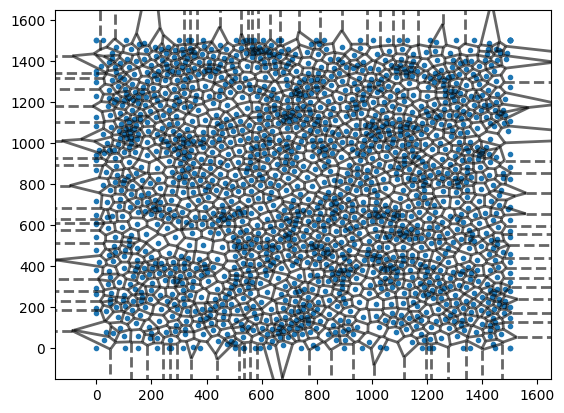

In [ ]:
new_vor = Voronoi(new_points)
voronoi_plot_2d(new_vor, show_vertices=False, line_width=2, line_alpha=0.6)
plt.show()

In [ ]:
#creates a kd tree containing all the sea points
#assigns elevation based on distance from nearest sea cell
def assign_elevation(points, land_and_sea):
  points = np.array(points)
  sea_points = [points[i] for i in range(len(points)) if land_and_sea[i] == 0]

  tree = cKDTree(sea_points)

  elevation = []

  for i, p in enumerate(points):
      if land_and_sea[i] == 0:
          elevation.append(0.0)
      else:
          #find nearest sea point
          dist, _ = tree.query(p)
          elevation.append(dist)

  # normalizing
  elevation = np.array(elevation)
  if elevation.max() > 0:
      elevation /= elevation.max()

  return elevation

In [ ]:
def assign_freshwater(points, elevation, land_and_sea, target_elev=0.5, tolerance=0.1, fraction=0.2):
    freshwater = np.zeros(len(points), dtype=int)

    candidate_idx = np.where((land_and_sea == 1) &
                             (elevation >= target_elev - tolerance) &
                             (elevation <= target_elev + tolerance))[0]

    n_fresh = max(1, int(len(candidate_idx) * fraction))
    selected_idx = np.random.choice(candidate_idx, n_fresh, replace=False)

    freshwater[selected_idx] = 1
    return freshwater

In [ ]:
def assign_moisture(points, land_and_sea, freshwater):
    moisture = np.zeros(len(points))

    land_idx = np.where(land_and_sea == 1)[0]
    freshwater_idx = np.where(freshwater == 1)[0]

    if len(freshwater_idx) == 0:
        return moisture

    tree = cKDTree(points[freshwater_idx])
    distances, _ = tree.query(points[land_idx])

    max_dist = distances.max() if distances.max() > 0 else 1
    moisture_land = 1 - (distances / max_dist)

    moisture[land_idx] = moisture_land
    return moisture

In [ ]:
#generates land and sea assignments using perlin noise
#for each point, generate a value using perlin noise and normalize to [0, 1]
#perlin noise generates a kind of smooth heightmap so points close to each other have similar values

def assign_attributes(points, scale=2.0, threshold=0.75):
  cx = (points[:,0].min() + points[:,0].max()) / 2
  cy = (points[:,1].min() + points[:,1].max()) / 2

  dx = points[:,0] - cx
  dy = points[:,1] - cy
  dist_norm = np.sqrt(dx*dx + dy*dy)
  dist_norm = dist_norm / dist_norm.max()

  shape = 1 - dist_norm

  offset_x = np.random.rand() * 100
  offset_y = np.random.rand() * 100

  x_norm = (points[:,0] - points[:,0].min()) / np.ptp(points[:,0])
  y_norm = (points[:,1] - points[:,1].min()) / np.ptp(points[:,1])

  noise = np.array([
      pnoise2(x * scale + offset_x, y * scale + offset_y)
      for x, y in zip(x_norm, y_norm)
  ]) + 0.5

  island_mask = shape + 0.5 * noise

  land_and_sea = (island_mask > threshold).astype(int)

  #assign elevation
  elevation = assign_elevation(points, land_and_sea)

  #assign freshwater
  freshwater = assign_freshwater(points, elevation, land_and_sea)

  #assign moisture
  moisture = assign_moisture(points, land_and_sea, freshwater)

  return land_and_sea, elevation, freshwater, moisture

In [ ]:
def biome_color(elev, moisture):
    if elev < 0.33:
        if moisture > 0.6: return "#3a5a40"   # Tropical Rainforest - middle
        elif moisture > 0.3: return "#21362b" # Savanna / Lowland Grassland - outer
        else: return "#402e28"               # Subtropical Desert

    elif elev < 0.66:
        if moisture > 0.6: return "#506e50"   # Temperate Forest - inner
        elif moisture > 0.3: return "#4c634c" # Temperate Grassland - middleish
        else: return "#6e5332"               # Temperate Desert

        # #638959, 0E5116, OF300F

    else:
        if moisture > 0.6: return "#9ab39a"   # Snow
        elif moisture > 0.3: return "#A3B18A" # Alpine Meadow / Scree with moss -- innermost, near white
        else: return "#dad7cd"               # Tundra / Cold Rock

In [ ]:
.#Plots the polygons of the Voronoi diagram after assigning a colour
def plot_coloured_voronoi(vor, attributes):
  fig, ax = plt.subplots(figsize=(8, 8))
  green_to_white = mcolors.LinearSegmentedColormap.from_list("green_to_white", ["green", "white"])

  land_and_sea, elevation, freshwater, moisture = attributes

  for point_index, region_index in enumerate(vor.point_region):
      region = vor.regions[region_index]


      # skip unbounded cells while plotting
      if -1 in region or len(region) == 0:
          continue

      polygon = vor.vertices[region]
      x, y = polygon[:,0], polygon[:,1]
      if (x < 0).any() or (x > canvasX).any() or (y < 0).any() or (y > canvasY).any():
            continue

      color = ""
      if land_and_sea[point_index] == 1:
        if(freshwater[point_index]) == 1:
          color = '#437491' # 051650
        else:
          color = biome_color(elevation[point_index], moisture[point_index])
      else:
        color = "#538db0" # 538db0

      ax.fill(*zip(*polygon), facecolor=color, edgecolor='none', linewidth=0, antialiased=True)

  ax.set_aspect('equal')
  plt.show()

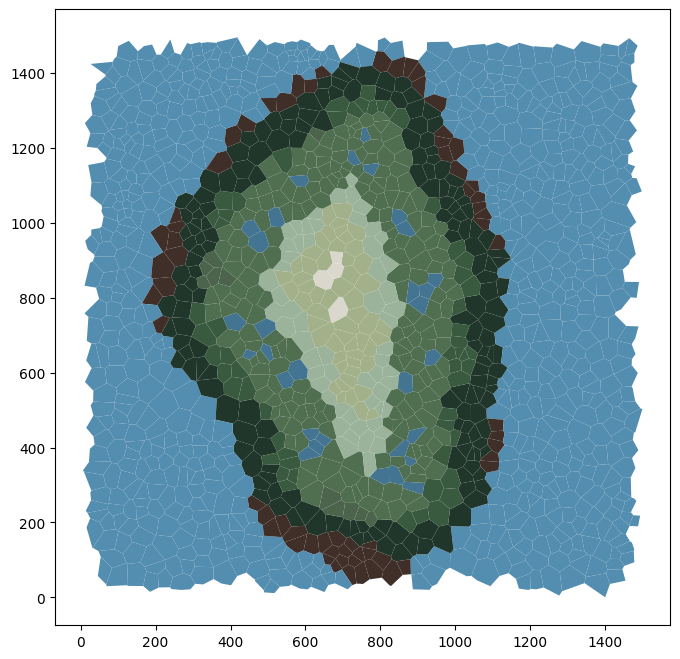

In [ ]:
attributes = assign_attributes(new_points)
plot_coloured_voronoi(new_vor, attributes)